In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import graphviz
import pandas_profiling
import matplotlib.pyplot as plt
import eli5
from eli5.sklearn import PermutationImportance
from IPython.display import Image
from IPython.core.display import HTML 
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix, precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from sklearn.utils.fixes import signature
from matplotlib.legend_handler import HandlerLine2D
from pdpbox import pdp, get_dataset, info_plots

%matplotlib inline

Columns:
* age - age in years
* sex - (1 = male; 0 = female)
* cp - chest pain type
* trestbps - resting blood pressure (in mm Hg on admission to the hospital)
* chol - serum cholestoral in mg/dl
* fbs - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
* restecg - resting electrocardiographic results
* thalach - maximum heart rate achieved
* exang - exercise induced angina (1 = yes; 0 = no)
* oldpeak - ST depression induced by exercise relative to rest
* slope - the slope of the peak exercise ST segment
* ca - number of major vessels (0-3) colored by flourosopy
* thal - 3 = normal; 6 = fixed defect; 7 = reversable defect, probably thalassemia 
* target - 1 or 0

In [2]:
path = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
columns = ["age", "sex", "cp", 
           "trestbps", "chol", "fbs", 
           "restecg", "thalach","exang", 
           "oldpeak","slope", "ca", "thal", "num"]

data_pd = pd.read_csv(path, header=None, names=columns, na_values=['?'])
data_pd['target'] = np.where(data_pd.num > 0, 1, 0)
data_pd.drop('num', inplace=True, axis=1)

data_pd = data_pd.dropna() # 4 records

In [3]:
pandas_profiling.ProfileReport(data_pd)

Number of variables,15
Number of observations,297
Total Missing (%),0.0%
Total size in memory,34.9 KiB
Average record size in memory,120.3 B
Numeric,11
Categorical,0
Boolean,4
Date,0
Text (Unique),0
Rejected,0


### Logistic Regression

Basic Training (train/test split)

In [4]:
X = data_pd[data_pd.columns[:-1]]
y = data_pd['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y) #default test split is 0.25 

## Basic logistic regression model - with all features and with default hyperparameters

In [5]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_train)
print('Accuracy of logistic regression classifier on train set: {:.2f}'.format(logreg.score(X_train, y_train)))
print(classification_report(y_train, y_pred))
print(confusion_matrix(y_train, y_pred))

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy of logistic regression classifier on train set: 0.88
              precision    recall  f1-score   support

           0       0.87      0.92      0.89       120
           1       0.90      0.84      0.87       102

   micro avg       0.88      0.88      0.88       222
   macro avg       0.88      0.88      0.88       222
weighted avg       0.88      0.88      0.88       222

[[110  10]
 [ 16  86]]
Accuracy of logistic regression classifier on test set: 0.80
              precision    recall  f1-score   support

           0       0.78      0.88      0.82        40
           1       0.83      0.71      0.77        35

   micro avg       0.80      0.80      0.80        75
   macro avg       0.81      0.79      0.80        75
weighted avg       0.80      0.80      0.80        75

[[35  5]
 [10 25]]


The upper left corner of the confusion matrix - how many true 0s were identified as 0s (true negative). The lower right corner - how many of true 1s were identified as 1s (true positive).

#### Precision - of those classified as having a heart disease, what proportion actually were having a heart disease (positive predictive value)
#### Recall - of those actually having a heart disease how many were classified this way (true positive rate, 1 - false negative rate)

In [12]:
path = "https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/350px-Precisionrecall.svg.png"
Image(url= path)

## Cross validation - better way to test your predictions

In [6]:
path = "https://3gp10c1vpy442j63me73gy3s-wpengine.netdna-ssl.com/wp-content/uploads/2018/03/Screen-Shot-2018-03-21-at-4.26.53-PM.png"
Image(url= path)

In [7]:
kfold = KFold(n_splits=5, random_state=7)
modelCV = LogisticRegression()
scoring = 'recall'
results = cross_val_score(modelCV, X_train, y_train, cv=kfold, scoring=scoring) 
print("5-fold cross validation average recall: %.3f" % (results.mean()))

5-fold cross validation average recall: 0.772


## Grid search - run multiple models with different (predefined) hyperparameters to obtain the model with the highest score

In [8]:
parameters = {
    'penalty' : ['l1', 'l2'],
     'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
}

grid_search = GridSearchCV(LogisticRegression(), 
                   parameters, 
                   cv=5, 
                   scoring='recall', 
                   refit=True,
                   return_train_score=True, 
                   n_jobs=-1)
grid_search.fit(X_train, y_train)

print(grid_search.best_score_)
print(grid_search.best_params_)

grid_logreg = grid_search.best_estimator_
y_pred = grid_logreg.predict(X_test)
y_proba = grid_logreg.predict_proba(X_test)[:,1]

0.8038610038610039
{'C': 0.1, 'penalty': 'l2'}


### Metrics

Let's see a classification report and confusion matrix 

In [10]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(grid_logreg.score(X_test, y_test)))

[[33  7]
 [11 24]]
              precision    recall  f1-score   support

           0       0.75      0.82      0.79        40
           1       0.77      0.69      0.73        35

   micro avg       0.76      0.76      0.76        75
   macro avg       0.76      0.76      0.76        75
weighted avg       0.76      0.76      0.76        75

Accuracy of logistic regression classifier on test set: 0.76


## Let's plot the confusion matrix - with normalization and without. As classes are not equal, the normalization will allow for more robust analysis of what's going on in the confusion matrix

Confusion matrix, without normalization
[[33  7]
 [11 24]]
Normalized confusion matrix
[[0.825      0.175     ]
 [0.31428571 0.68571429]]


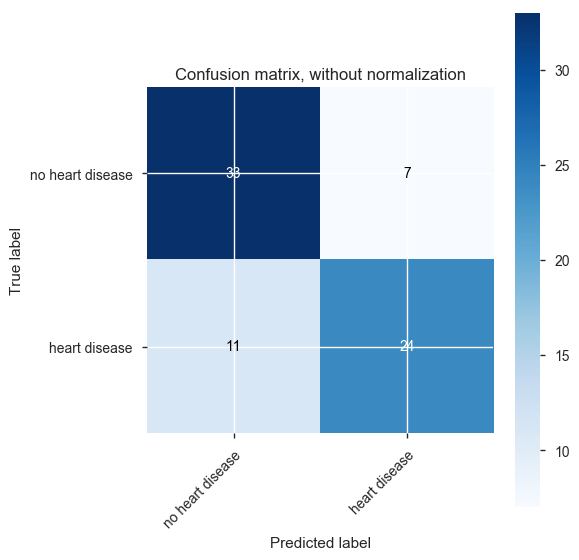

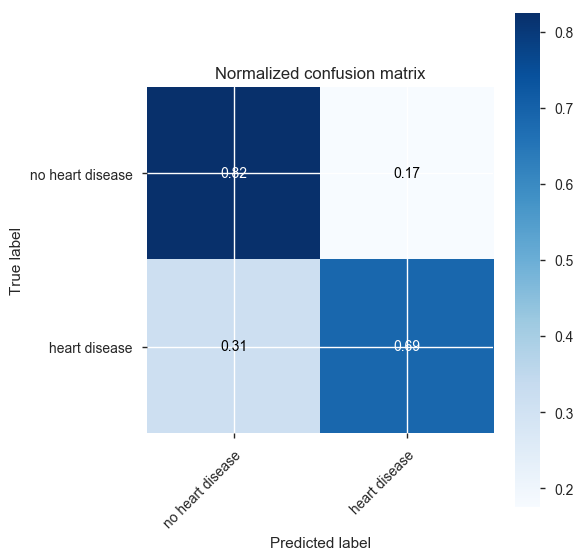

In [11]:
## This code can be found here https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize = (6,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax



class_names =['no heart disease', 'heart disease']
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### Let's draw a precision-recall curve for the last model, this will show a trade-off between those two


## Precision - recall trade-off.  If you have to recall everything, you will have to keep generating results which are not accurate, hence lowering your precision. In most extreme case you can build a model that will always predict 1s and your recall will be 100%, but your precision will be low.

Average precision-recall score: 0.82


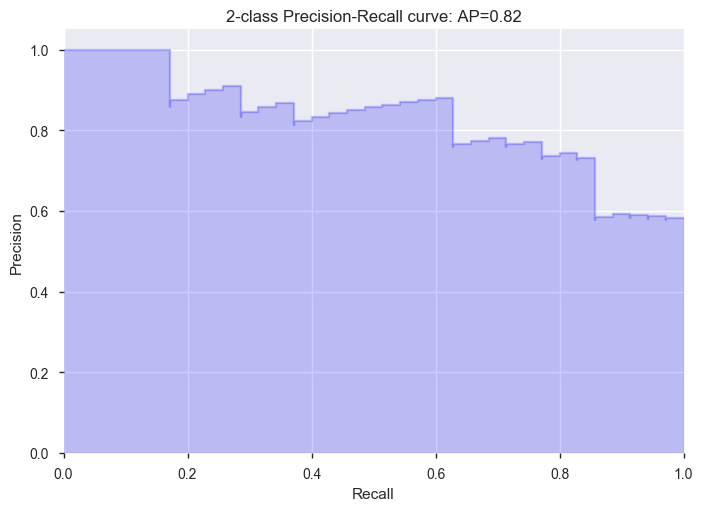

In [13]:
average_precision = average_precision_score(y_test, y_proba)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

precision, recall, _ = precision_recall_curve(y_test, y_proba)

step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

plt.show()

### Let's now draw a ROC curve. It's different from precision-recall plot as it plots a true positive rate vs false positive rate at different probability thresholds. 

AUC: 0.842


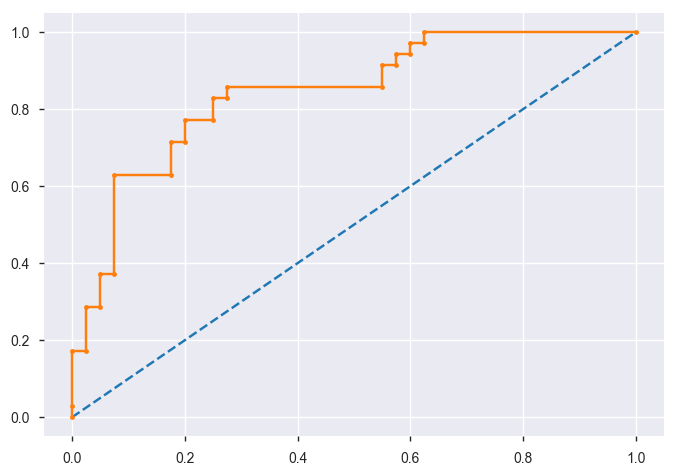

In [14]:
auc_score = roc_auc_score(y_test, y_proba)
print('AUC: %.3f' % auc_score)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

### Logistic Regression Interpretation

Coefficients

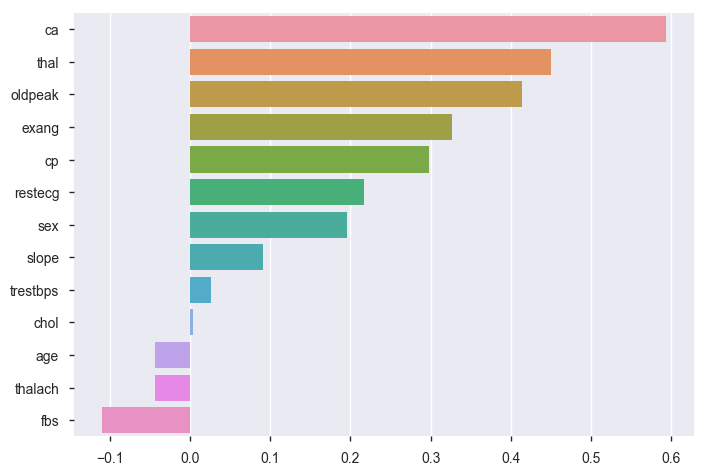

In [15]:
coefs = zip(grid_logreg.coef_[0], data_pd.columns.tolist()[:-1])
coefs = np.array(sorted(coefs, key=lambda x: x[0], reverse=True))

sns.barplot(x=coefs[:, 0].astype(float), y=coefs[:, 1])

Odds ratios 

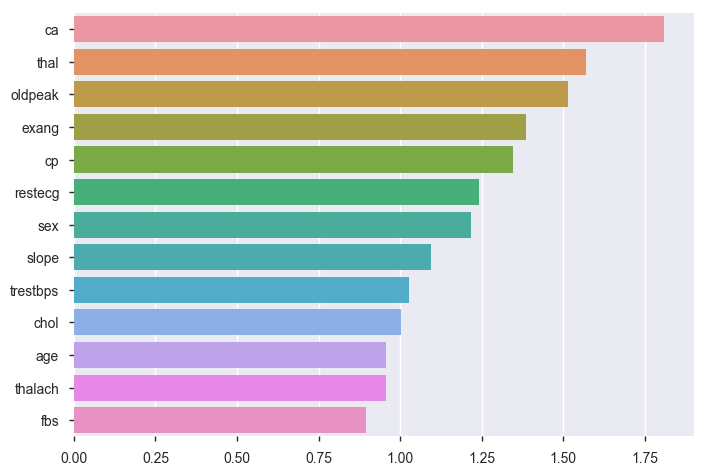

In [16]:
coefs = zip(np.exp(grid_logreg.coef_[0]), data_pd.columns.tolist()[:-1])
coefs = np.array(sorted(coefs, key=lambda x: x[0], reverse=True))

sns.barplot(x=coefs[:, 0].astype(float), y=coefs[:, 1])

#### Another approach to feature importance - permutation tests! 

In [17]:
perm = PermutationImportance(grid_logreg, n_iter = 50).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = data_pd.columns.tolist()[:-1])

Weight,Feature
0.0907 ± 0.0727,thal
0.0557 ± 0.0733,thalach
0.0309 ± 0.0408,ca
0.0123 ± 0.0276,cp
0.0064 ± 0.0460,oldpeak
0.0045 ± 0.0165,slope
0.0029 ± 0.0171,sex
0.0005 ± 0.0226,exang
-0.0053 ± 0.0302,chol
-0.0083 ± 0.0324,restecg


### Decision Tree

In [18]:
def get_auc(dt, X, y):
    y_pred = dt.predict(X)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y, y_pred)
    return auc(false_positive_rate, true_positive_rate)

In [19]:
dt = tree.DecisionTreeClassifier()
dt.fit(X_train, y_train)


print('Metrics on TRAIN SET:')
y_pred = dt.predict(X_train)
print('Accuracy of Decision Tree classifier on train set: {:.2f}'.format(dt.score(X_train, y_train)))
print(classification_report(y_train, y_pred))
print(confusion_matrix(y_train, y_pred))


print('\nMetrics on TEST SET:')
y_pred = dt.predict(X_test)
print('Accuracy of Decision Treeclassifier on test set: {:.2f}'.format(dt.score(X_test, y_test)))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Metrics on TRAIN SET:
Accuracy of Decision Tree classifier on train set: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       120
           1       1.00      1.00      1.00       102

   micro avg       1.00      1.00      1.00       222
   macro avg       1.00      1.00      1.00       222
weighted avg       1.00      1.00      1.00       222

[[120   0]
 [  0 102]]

Metrics on TEST SET:
Accuracy of Decision Treeclassifier on test set: 0.69
              precision    recall  f1-score   support

           0       0.68      0.80      0.74        40
           1       0.71      0.57      0.63        35

   micro avg       0.69      0.69      0.69        75
   macro avg       0.70      0.69      0.69        75
weighted avg       0.70      0.69      0.69        75

[[32  8]
 [15 20]]


Tree visuallization:

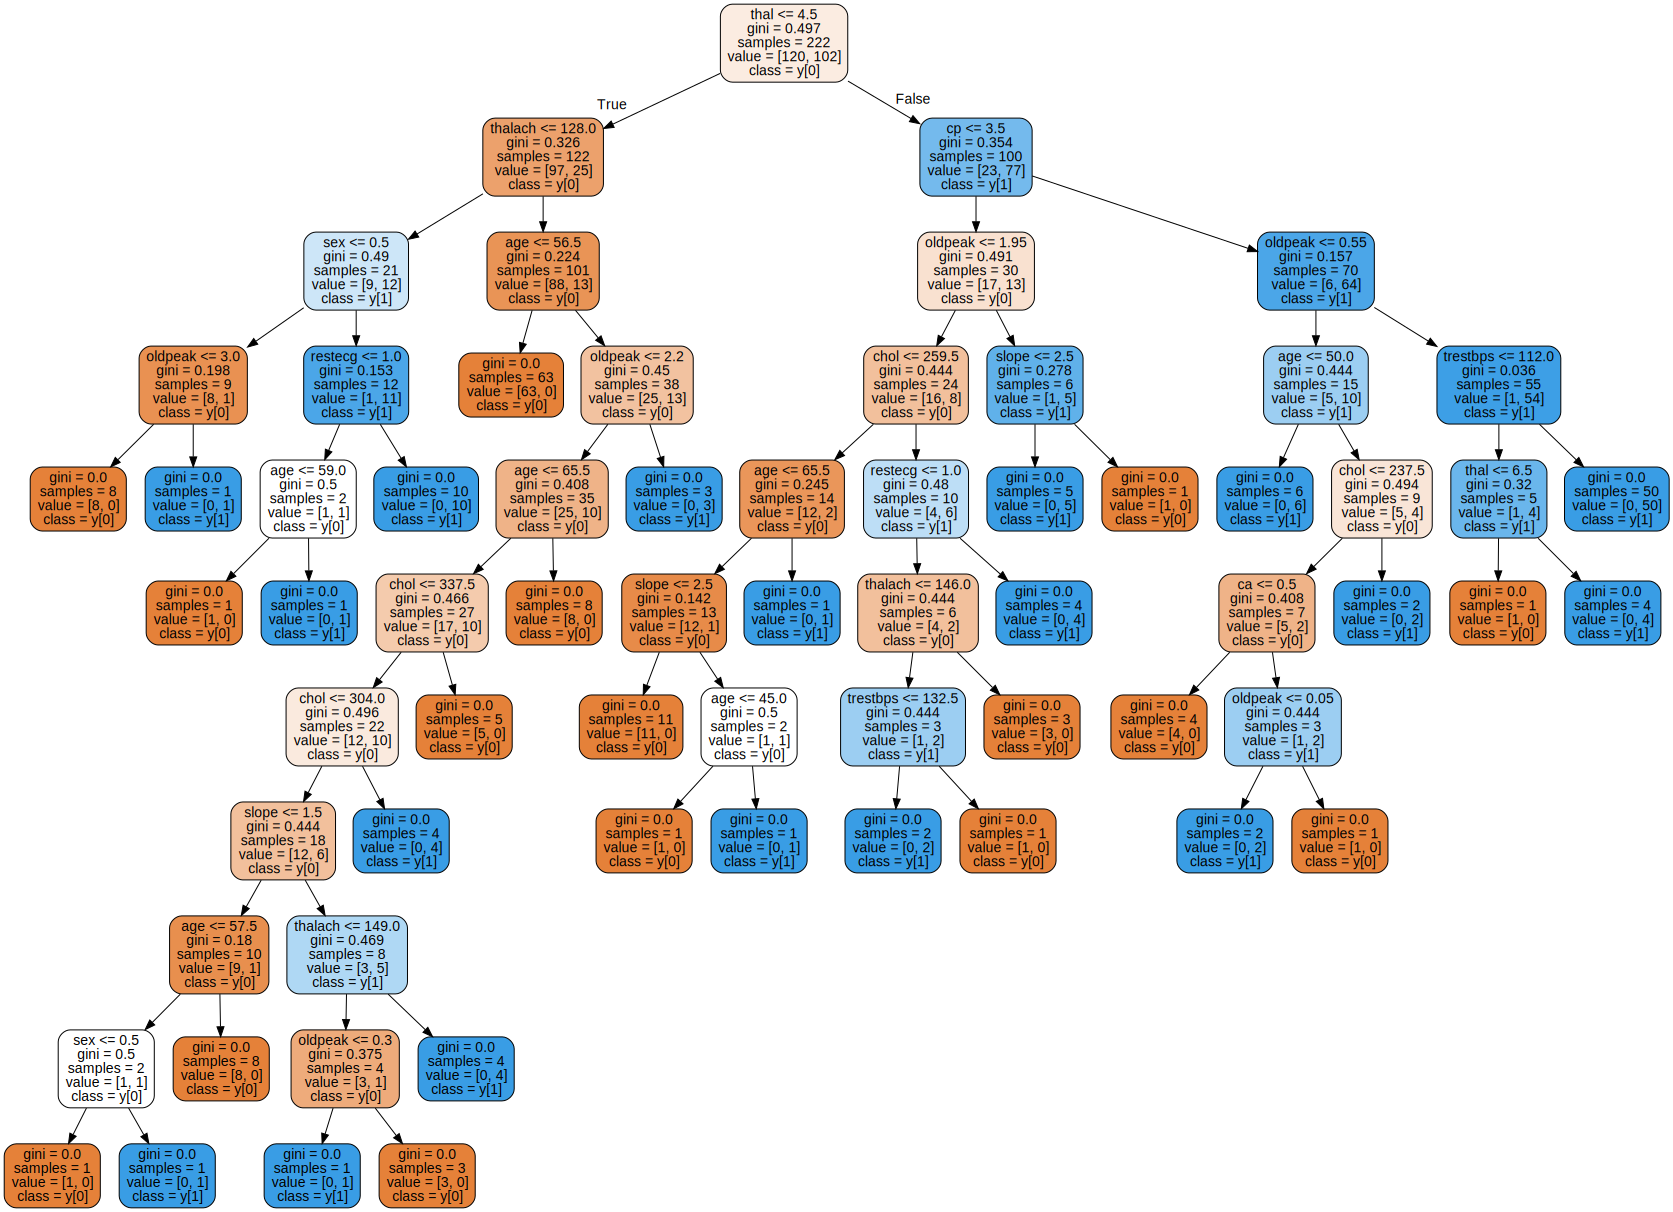

In [23]:
dot_data = tree.export_graphviz(dt, feature_names=data_pd.columns[:-1],  
                                out_file=None, class_names=True,
                                filled=True, rounded=True)  
graphviz.Source(dot_data)

By comparing results between train and test sets we can notice that decision tree is overfitting. It has learnt training set perfectly, but performs poorly on the test set. One possible explanation could be that the model is too complicated and it fits the training data too well. 

Lets try to validate that by manipulating tree parameters.

Among others some important ones are:
* **max_depth** (default=None) - The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
* **min_samples_split** (default=2) - The minimum number of samples required to split an internal node (number or fraction of all samples)
* **min_samples_leaf** (default=1) - The minimum number of samples required to be at a leaf node (number or fraction)
* **max_features** (default=None) - The number of features to consider when looking for the best split (number, fraction, sqrt or log2).


Lets see what's the effect of manipulating each of those parameters seprately:

In [ ]:
def get_auc(dt, X, y):
    y_pred = dt.predict(X)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y, y_pred)
    return auc(false_positive_rate, true_positive_rate)

def plot_parameter_search(X_train, y_train, X_test, y_test, param_values, param_name):
    train_results = []
    test_results = []

    for val in param_values:
        dt = tree.DecisionTreeClassifier(**{param_name: val})
        dt.fit(X_train, y_train)

        train_results.append(get_auc(dt, X_train, y_train))
        test_results.append(get_auc(dt, X_test, y_test))

    line1, = plt.plot(param_values, train_results, 'b', label='Train AUC')
    line2, = plt.plot(param_values, test_results, 'r', label='Test AUC')
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('AUC score')
    plt.xlabel(param_name)
    plt.show()


parameters = {
    'max_depth': np.linspace(1, 10, 20, endpoint=True),
    'min_samples_leaf': np.linspace(0.01, 0.5, 10, endpoint=True),
    'min_samples_split': np.linspace(0.0001, 1.0, 10, endpoint=True),
    'max_features': list(range(1, int(X_train.shape[1] / 2))),
    
}
    
for param, values in parameters.items():
    plot_parameter_search(X_train, y_train, X_test, y_test, values, param)

But can we look at this plots separately to pick the best parameters?

Lets see what happens when we repeat max_features plot with different max_depth:

In [ ]:
train_results = []
test_results = []

for val in parameters['max_features']:
    dt = tree.DecisionTreeClassifier(**{'max_features': val, 'max_depth': 4})
    dt.fit(X_train, y_train)

    train_results.append(get_auc(dt, X_train, y_train))
    test_results.append(get_auc(dt, X_test, y_test))

line1, = plt.plot(parameters['max_features'], train_results, 'b', label='Train AUC')
line2, = plt.plot(parameters['max_features'], test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('max_features (max_depth=4)')
plt.show()

That's why we need to check all possible combinations of parameters with **Grid Search**:

In [ ]:
grid_search = GridSearchCV(tree.DecisionTreeClassifier(), 
                   parameters, 
                   cv=5, 
                   scoring='recall', 
                   refit=True,
                   return_train_score=True, 
                   n_jobs=-1)
grid_search.fit(X_train, y_train)

print(grid_search.best_score_)
print(grid_search.best_params_)

clf = grid_search.best_estimator_

Metrics again:

In [ ]:
print('Metrics on TRAIN SET:')
y_pred = clf.predict(X_train)
print('Accuracy of logistic regression classifier on train set: {:.2f}'.format(clf.score(X_train, y_train)))
print(classification_report(y_train, y_pred))
print(confusion_matrix(y_train, y_pred))


print('\nMetrics on TEST SET:')
y_pred = clf.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(clf.score(X_test, y_test)))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

In [ ]:
dot_data = tree.export_graphviz(clf, feature_names=data_pd.columns[:-1],  
                                out_file=None, class_names=True,
                                filled=True, rounded=True)  
graphviz.Source(dot_data)  

Which features are imporant?

In [ ]:
coefs = zip(clf.feature_importances_, data_pd.columns.tolist()[:-1])
coefs = np.array(sorted(coefs, key=lambda x: x[0], reverse=True))

sns.barplot(x=coefs[:, 0].astype(float), y=coefs[:, 1])

In [ ]:
perm = PermutationImportance(clf, n_iter = 50).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = data_pd.columns.tolist()[:-1])